# Multivariate Probit regression

In this recipe we will explore how to use JAX to fit multivariate probit models. For one dimensional target response, probit models can be seen as a logistic regression with a different link function (probit - the cdf of a normal distribution vs logit function). When analysing multivariate data, those models have the additional potential of estimating the correlation structure between multiple response variables, even after conditioning on all covariates. This can make those models robust to missing covariates that would be predictive of multiple outcomes.

For example, let's imagine that we are interested in modeling a population that can go to two nearby stores, we can record a limited set of covariates (say age, gender, income) and the visits of each individual ($y_1, y_2 \in \{0, 1\}$) to each respective store. Since they are close by, it is pretty clear that being able to go to the first one will positively impact the possibility of going to the second one, even after demographic covariates have been taken into account. From a modeling perspective we could argue that there exists a latent variable that we could interpret as "possibility and willingness to go to the area close to the two stores" that is not fully explained by known covariates, and that has a significant impact on each response.

Those models are interesting in the cases where we need to query the joint distribution between binary responses. E.g. answering questions like: how much does going to the first store increase the probability of going to the second store? Or what is the probability to going to none of the stores?

While doing exploring those models, several interesting and more general topics will pop up:
- Optimization of a stochastic loss
- Speeding up optimization when loss is slow to compute
- Building confidence intervals for optimizers of those problems
- Rejection sampling using compiled JAX code
- Use of sampling for Monte-Carlo EM methods


## Model specification

### Notations

Here, we are therefore interested in a multivariate binary response $y \in R^{n \times q}$ where $n$ is the sample size, and $q$ is the number of responses of interest. Here, we will study $q=2$, but the approach will remain general.

We are given a set of $p$ covariates for each sample, which we will concatenate in a single design matrix $X \in R^{n \times p}$.
Those covariates have an influence on each response through some linear parameters $\beta \in R^{p \times q}$.

The noise in the model will come from correlated residuals $\epsilon_i \sim N(0, \Sigma)$ with $\Sigma \in R^{q \times q}$ for $i \in \{ 1, ..., n \}$.

Let's define the _continuous response_ $y^* = X \beta + \epsilon $. Note that, to keep notations close to a univariate regression, we will keep lowercase letters, eventhough all quantities involved are now matrices. This linear relation creates a slight identification problem between $\Sigma$ and $\beta$ that is solved by constraining $\Sigma$'s diagonal to $1$'s.

The binary _observed_ response is gotten by setting $y$ to $1$ if $y^*$ is positive, and $0$ otherwise.

More formally, $y_{i,j} = 1(y^*_{i, j \gt 0})$ for $i = 1, ..., n$ and $j = 1, ..., p$

### Interpretation

While familiar in places, this specification can seem a little cryptic at first. The first thing to realize is that for each response it can be simplified to a univariate probit regression:
$$ P(y_1 = 1) = P(y^*_1 > 0) = P( (X \beta)_1 + \epsilon_1 > 0) = P( \epsilon_1 > -(X \beta)_1) = \Phi((X \beta)_1) $$
(Since $\epsilon_1$ is a univariate standard normal.), where $\Phi$ is the cdf of a standard normal.
This is the same thing as a logistic regression with a probit link instead of logit.

This has the non-trivial implication that the lines of $\beta$ can be estimated independently via separate univariate probit regressions. We could also add another response to the model as needed (in the example, a third store), and not start from a completely new, unestimated model. This, however, does not tell us how to fit the correlation matrix.


## Generating data

Let's sample some data to play with and understand how to fit and use those models.


In [1]:
import jax
import jax.random as random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import NamedTuple, Any


plt.style.use('ggplot')

In [2]:
# Sample data
key = random.PRNGKey(20220526)

n = 10_000 # Sample size
p = 10 # Predictor
q = 2 # Targets

key, skey = random.split(key)
x = random.normal(skey, (n, p))

key, skey = random.split(key)
beta = random.normal(skey, (p, q))

# Covariance matrix
rho = 0.9
sigma = jnp.array([
    [1.0, rho],
    [rho, 1.0],
])
u = jnp.real(jax.scipy.linalg.sqrtm(sigma))

r = sigma / (1 - rho) - jnp.eye(q)
sqrt_r = jnp.real(jax.scipy.linalg.sqrtm(r))

key, skey = random.split(key)
eps = random.normal(skey, (n, q)) @ u

y_star_mu = x @ beta + eps
y = (y_star_mu >= 0).astype('int32')

[[0.99999994 0.8991772 ]
 [0.8991772  1.        ]]


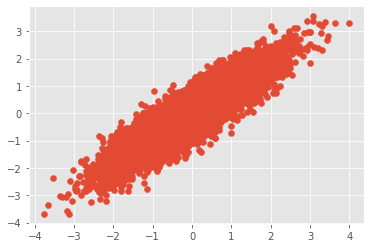

In [3]:
plt.scatter(eps[:, 0], eps[:, 1])
print(jnp.corrcoef(eps.T))

[[1.         0.37207174]
 [0.37207174 1.        ]]


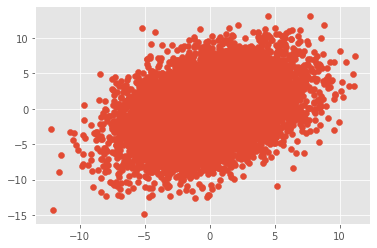

In [4]:
plt.scatter(y_star_mu[:, 0], y_star_mu[:, 1])
print(jnp.corrcoef(y_star_mu.T))

We use random covariates and a correlation on the residuals of $0.9$. We can see that $\epsilon$ exhibits this correlation.
The correlation in $y^*$ is attributable to X and the residuals (note the different scales on the two plots).

## Fitting marginals

Let's use the property that each marginal response can be fitted with a univariate probit regression.

In [5]:
# Fitting without correlation
# This loss assumes independence of outcomes given X

def loss(beta, x, y):
    w = x @ beta
    
    logcdf = jax.scipy.stats.norm.logcdf(w)
    logsf = jax.scipy.stats.norm.logcdf(-w)
    
    log_prob = y * logcdf + (1 - y) * logsf
    return -jnp.sum(log_prob) / y.shape[0]

loss(beta, x, y)

DeviceArray(0.43492714, dtype=float32)

In [6]:
# We optimize using BFGS, which requires a flat vector.
import jax.scipy.optimize as sco

def loss2(beta_flat):
    beta = beta_flat.reshape((p, q))
    return loss(beta, x, y)

res = sco.minimize(loss2, jnp.zeros((p*q, )), method="BFGS")
beta_hat = res.x.reshape((p, q))

In [7]:
h_beta = jax.hessian(loss2)(res.x)
beta_hat_std = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_beta) / n)).reshape((p, q))

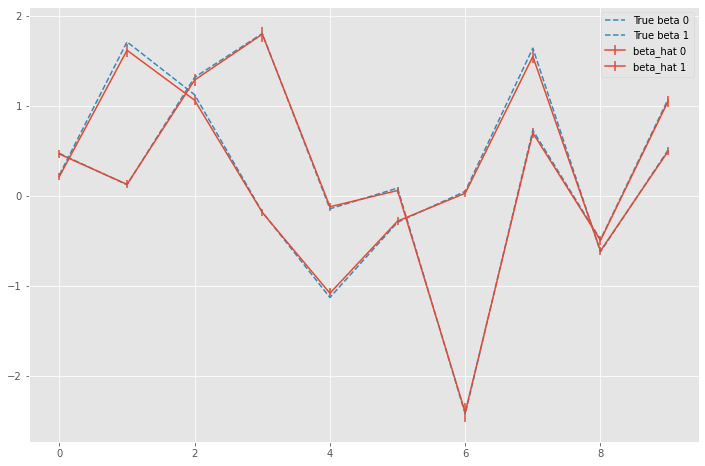

In [8]:
plt.figure(figsize=(12, 8))

for i in range(q):
    plt.errorbar(range(p), beta_hat[:, i], yerr=1.96 * beta_hat_std[:, i], color='C0', label=f'beta_hat {i}')
    plt.plot(beta[:, i], color='C1', linestyle='--', label=f'True beta {i}')

plt.legend()
plt.show()

In [9]:
z_scores = (beta_hat - beta) / beta_hat_std
z_scores.mean(), z_scores.std()

(DeviceArray(-0.52653337, dtype=float32),
 DeviceArray(1.0804704, dtype=float32))

We can see that the fitted values are close to the truth. Standard errors are computed from the hessian, they visually have the right scale and the z-scores have a standard error close to 1. All those things seem to indicate a good fit.

Are we missing a lot of correlation from there? We should be able to tell by taking a look at the residuals from the univariate regressions.

In [10]:
p_y_hat = jax.scipy.stats.norm.cdf(x @ beta_hat)
residuals = y - p_y_hat
jnp.corrcoef(residuals.T)

DeviceArray([[1.        , 0.19038962],
             [0.19038962, 1.        ]], dtype=float32)

There is indeed about 19% of correlation that is not explained by the covariates in $X$.

Another way to put this effect in perspective is by comparing the probability of both responses being = 1 according to the raw data and the model.


In [11]:
# P(Y1 = 1 and Y2 = 1)

p11 = jnp.mean(jnp.all(y == 1, axis=1))
p11_std = jnp.sqrt(p11 * (1 - p11) / n)

p11 + 1.96 * p11_std * jnp.array([-1, +1])

DeviceArray([0.2975628, 0.3156372], dtype=float32)

In [12]:

p11_uni = jnp.mean(jnp.prod(p_y_hat, axis=1))
# This does not take into account noise introduced by the estimation of beta
p11_uni_std = jnp.std(jnp.prod(p_y_hat, axis=1)) / jnp.sqrt(n)

p11_uni + 1.96 * p11_uni_std * jnp.array([-1, +1])

DeviceArray([0.28471676, 0.29951128], dtype=float32)

The two confidence intervals overlap sightly, and while the test is not completely rigorous (given that both estimators are correlated), assuming independence does seem to lead to a slight underestimation of $p_{11}$.
Depending on the usecase, it might make sense to stop here. We are going to investigate the correlation structure further and see if we can come up with better estimates and model fit.



## Fitting the correlation structure

The normal distribution is probably the easiest distribution to work with in higher dimensions with correlations. However, the truncation part of the probit model creates a lot of problems when trying to estimate parameters. If the shape of the likelihood is obviously not too disturbed by the truncation, the normalizing constants are obviously impacted and when $q$ is greater than $2$, no analytical formula can be used to write down the likelihood of a multivariate probit model.
There exists significant litterature on those issues. Here I would like to showcase one of the easier and more scalable idea - even though there are always going to be scalability problems with such models-.

In {cite}`ICML-2018-ChenXG`, Chen showcases how splitting the covariance matrix into a diagonal and a residual part can help estimate the likelihood by sampling from a normal distribution. They then show that the diagonal matrix can be reduced to the identity and it only suffices to estimate the residual covariance.

$\Sigma = I_q + \Sigma_r $ and $\Sigma_r = s^Ts$ so that $\Sigma_r$ is constrained to be positive semi definite, i.e. a valid covariance matrix.

In JAX, the parameters can be regrouped in a NamedTuple as follows, with $\beta$ and $s$ being the unconstrained parameters, and $\Sigma$ being completely specified by $s$.

In [13]:
class Params(NamedTuple):
    beta: jnp.array
    s: jnp.array
    
    @property
    def sigma(self):
        """Computes sigma from the square root of its residual, `s`."""
        s = self.s
        t = s.T @ s
        S = t + jnp.eye(q)
        sqrt_diag = jnp.sqrt(jnp.diag(S))
        # Normalize Sigma to a correlation matrix
        S = (S / sqrt_diag).T / sqrt_diag
        return S

true_params = Params(beta=beta, s=sqrt_r)
true_params, true_params.sigma

(Params(beta=DeviceArray([[ 0.23186858,  0.46960872],
              [ 1.709085  ,  0.12174629],
              [ 1.1210241 ,  1.3156708 ],
              [-0.1811214 ,  1.8010722 ],
              [-1.1304141 , -0.14554782],
              [-0.29495806,  0.08470398],
              [ 0.04848719, -2.4250152 ],
              [ 1.6395696 ,  0.7269019 ],
              [-0.6232631 , -0.48760355],
              [ 0.5079111 ,  1.0722051 ]], dtype=float32), s=DeviceArray([[2.1213205, 2.1213202],
              [2.1213202, 2.1213202]], dtype=float32)),
 DeviceArray([[1.        , 0.90000004],
              [0.90000004, 1.        ]], dtype=float32))

From there, Chen shows that the likelihood can be estimated with a Monte Carlo estimator based on samples of the normal distribution. See the paper for details. It is worth noting that if $s = 0$ then the loss is exactly the same as the univariate fits described earlier.

We note $m$ the number of Monte-Carlo samples used per sample for each evaluation of the loss / log-likelihood.

In [14]:
from functools import partial

@partial(jax.jit, static_argnums=(4,))
def loss(params, x, y, key, m=100):
    beta, s = params.beta, params.s
    
    z = random.normal(key, (m, x.shape[0], y.shape[1]))
    sigma_scale = jnp.sqrt(jnp.diag(jnp.eye(q) + s.T.dot(s)))

    w = x @ beta * sigma_scale  + z.dot(s)
    
    logcdf = jax.scipy.stats.norm.logcdf(w)
    logsf = jax.scipy.stats.norm.logcdf(-w)
    
    phi = y * logcdf + (1 - y) * logsf
    prod_phi = jnp.exp(phi.sum(axis=-1))
    prob = prod_phi.mean(axis=0)
    return -jnp.mean(jnp.log(prob))


In [16]:
%%time
loss(true_params, x, y, key, m=1000)

CPU times: user 5 s, sys: 480 ms, total: 5.48 s
Wall time: 487 ms


DeviceArray(0.4146354, dtype=float32)

At the true parameters, the loss is smaller than the optimal loss found for the univariate fits.
This _at least_ proves that a model with correlation fits better than a model with independent marginals.

However, even after JIT compilation, computing the loss can take half a second with $m=1000$ Monte Carlo samples. This can be a bit slow when trying to find the right parameters. We will adopt a flexible approach that will try to minimize fitting time.

### Parameter estimation

We choose to minimize the loss by stochastic gradient descent with momentum. The loss being stochastic (because of the Monte-Carlo estimation), gradient methods are more robust. Second order methods use too much unreliable information in those cases to be reliable. Momentum however is a good idea to smooth the gradient over several iterations of training, which is ideal in cases where the loss has some randomness. Finally the stochastic aspect of the descent (by which we mean using batches of data points instead of the entire dataset at each iteration) will help shorten the computation time of the loss and its gradient.

Here is the proposed procedure:

In [17]:
import optax

def fit_params(
    init_params, x, y, key,
    n_iterations = 100,
    batch_size = 100,
    lr = 1.0,
    momentum=.9,
    m=100,
):
    params = init_params
    hist = {'f': [], 'g_norm': []}
    optimizer = optax.sgd(learning_rate=lr, momentum=momentum)
    opt_state = optimizer.init(params)
    
    @jax.jit
    def update(params, x, y, key, opt_state):
        f, g = jax.value_and_grad(loss)(params, x, y, key, m)
        updates, opt_state = optimizer.update(g, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, f, jnp.linalg.norm(g.beta)
    
    for i in range(n_iterations):
        key, skey = random.split(key)
        j = i % (y.shape[0] // batch_size)
        x_batch = x[j * batch_size: (j + 1) * batch_size]
        y_batch = y[j * batch_size: (j + 1) * batch_size]
        
        params, opt_state, f, g_norm = update(params, x_batch, y_batch, skey, opt_state)
        hist['f'].append(f)
        hist['g_norm'].append(g_norm)
    
    hist['f'] = jnp.stack(hist['f'])
    hist['g_norm'] = jnp.stack(hist['g_norm'])
    
    return params, hist


In [23]:
random.permutation(key, 10)

DeviceArray([7, 8, 6, 1, 4, 9, 5, 0, 2, 3], dtype=int32)

In [25]:
import optax


def create_batches(x, y, key, batch_size):
    n = x.shape[0]
    n_iterations = n // batch_size
    perm = random.permutation(key, n)
    for i in range(n_iterations):
        x_batch = x[perm[i * batch_size: (i + 1) * batch_size]]
        y_batch = y[perm[i * batch_size: (i + 1) * batch_size]]
        yield x_batch, y_batch


def fit_params(
    init_params, x, y, key,
    n_epochs = 10,
    batch_size = 100,
    lr = 1.0,
    momentum=.9,
    m=100,
):
    params = init_params
    hist = {'f': [], 'g_norm': []}
    optimizer = optax.sgd(learning_rate=lr, momentum=momentum)
    opt_state = optimizer.init(params)
    
    @jax.jit
    def update(params, x, y, key, opt_state):
        f, g = jax.value_and_grad(loss)(params, x, y, key, m)
        updates, opt_state = optimizer.update(g, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, f, jnp.linalg.norm(g.beta)
    
    for e in range(n_epochs):
        key, skey = random.split(key)
        for x_batch, y_batch in create_batches(x, y, skey, batch_size):
            key, skey = random.split(key)
            params, opt_state, f, g_norm = update(params, x_batch, y_batch, skey, opt_state)
            hist['f'].append(f)
            hist['g_norm'].append(g_norm)
    
    hist['f'] = jnp.stack(hist['f'])
    hist['g_norm'] = jnp.stack(hist['g_norm'])
    
    return params, hist


We want to start with `m` and `batch_size` as low as possible to minimize compute times, and increase them if the loss is too unstable to be optimized.

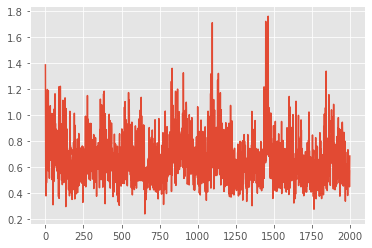

CPU times: user 36.4 s, sys: 5.91 s, total: 42.3 s
Wall time: 15.2 s


(DeviceArray(0.62745786, dtype=float32),
 DeviceArray(0.14531018, dtype=float32))

In [32]:
%%time

params = Params(
    beta=jnp.zeros((p, q)),
    s=jnp.zeros((q, q)),
)
key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=100, lr=1.0, m=100)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()


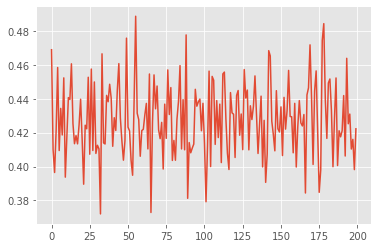

CPU times: user 18.7 s, sys: 3.46 s, total: 22.2 s
Wall time: 4.82 s


(DeviceArray(0.42819753, dtype=float32),
 DeviceArray(0.02123322, dtype=float32))

In [35]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=1000, lr=1.0, m=100)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

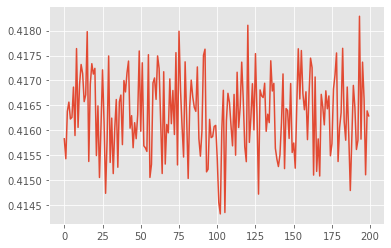

CPU times: user 3min 43s, sys: 33.3 s, total: 4min 16s
Wall time: 33.8 s


(DeviceArray(0.41627634, dtype=float32),
 DeviceArray(0.00080547, dtype=float32))

In [37]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=200, batch_size=10_000, lr=1.0, m=100)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

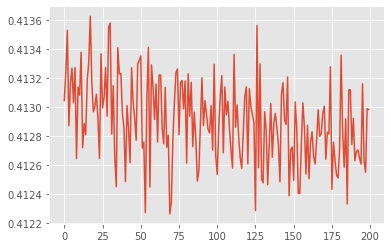

CPU times: user 32min 44s, sys: 0 ns, total: 32min 44s
Wall time: 3min 27s


(DeviceArray(0.41281632, dtype=float32),
 DeviceArray(0.00025124, dtype=float32))

In [38]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=200, batch_size=10_000, lr=1.0, m=1000)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

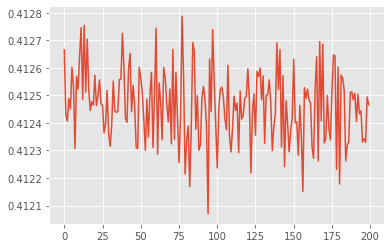

CPU times: user 2h 36min 11s, sys: 4min 52s, total: 2h 41min 3s
Wall time: 19min 55s


(DeviceArray(0.41244575, dtype=float32), DeviceArray(0.0001209, dtype=float32))

In [39]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=200, batch_size=10_000, lr=1.0, m=4000)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()


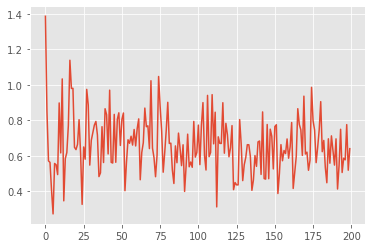

CPU times: user 4 s, sys: 1.21 s, total: 5.21 s
Wall time: 2.25 s


(DeviceArray(0.63936305, dtype=float32),
 DeviceArray(0.14108986, dtype=float32))

In [17]:
%%time

params = Params(
    beta=jnp.zeros((p, q)),
    s=jnp.zeros((q, q)),
)
key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_iterations=200, batch_size=100, lr=1.0, m=100)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

We quickly hit a stage where the loss is very noisy. Let's try to understand which variable to choose, between `m` and `batch_size`

In [18]:
# estimate batch_size noise

repetition = jax.jit(lambda x, y: loss(params, x, y, key, m=100))
reps = []
batch_size = 100
for i in range(n // batch_size):
    x_batch = x[i * batch_size: (i + 1) * batch_size]
    y_batch = y[i * batch_size: (i + 1) * batch_size]
    reps.append(repetition(x_batch, y_batch))
reps = jnp.array(reps)

reps.mean(), reps.std()

(DeviceArray(0.6053078, dtype=float32), DeviceArray(0.11591936, dtype=float32))

In [19]:
%%time
repetition = jax.jit(lambda key: loss(params, x, y, key, m=100))
reps = []
for i in range(100):
    key, skey = random.split(key)
    reps.append(repetition(key))
reps = jnp.array(reps)
reps.mean(), reps.std()

CPU times: user 50.6 s, sys: 361 ms, total: 50.9 s
Wall time: 5.41 s


(DeviceArray(0.604023, dtype=float32), DeviceArray(0.00101735, dtype=float32))

Noise is clearly dominated by batching noise, therefore let's increase `batch_size` and continue optimization.

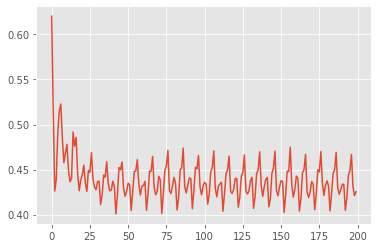

CPU times: user 15.7 s, sys: 1.03 s, total: 16.7 s
Wall time: 3.37 s


(DeviceArray(0.43449146, dtype=float32), DeviceArray(0.0169203, dtype=float32))

In [20]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_iterations=200, batch_size=1000, lr=1.0, m=100)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

Again, noise is dominated by batching noise, therefore let's increase `batch_size`.

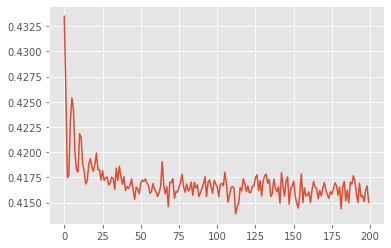

CPU times: user 2min 19s, sys: 32.6 s, total: 2min 51s
Wall time: 20.2 s


(DeviceArray(0.41626275, dtype=float32),
 DeviceArray(0.00087825, dtype=float32))

In [21]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_iterations=200, batch_size=10_000, lr=1.0, m=100)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

Batch size has been maxed out (since every batch is the full dataset, and the noise in the last iterations are about equal to the noise estimated by the Monte-Carlo noise. We need to increase $m$

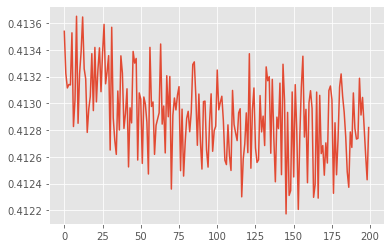

CPU times: user 28min 13s, sys: 1min 31s, total: 29min 44s
Wall time: 2min 55s


(DeviceArray(0.41280296, dtype=float32), DeviceArray(0.0002875, dtype=float32))

In [22]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_iterations=200, batch_size=10_000, lr=1.0, m=1_000)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

Note that the computation times are getting longer. Once again, we are hitting Monte-Carlo noise. My machine only allows me to go to $m=4000$ before using its swap memory, so I will perform a final iteration to polish the optimizer!


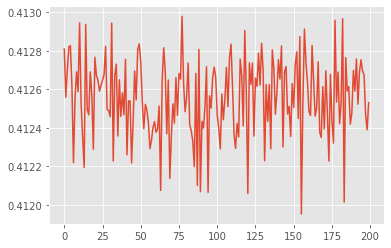

CPU times: user 58min 15s, sys: 2min 59s, total: 1h 1min 14s
Wall time: 5min 56s


(DeviceArray(0.41256946, dtype=float32), DeviceArray(0.0001959, dtype=float32))

In [23]:
%%time

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_iterations=200, batch_size=10_000, lr=1.0, m=2_000)
plt.plot(hist['f'])
plt.show()

hist['f'][-100:].mean(), hist['f'][-100:].std()

### Point estimates


In [24]:
params.sigma

DeviceArray([[1.        , 0.9017381 ],
             [0.90173817, 1.0000001 ]], dtype=float32)

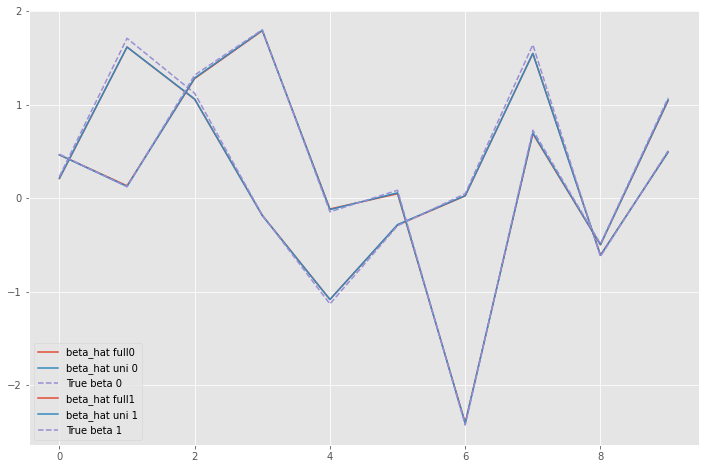

In [25]:
plt.figure(figsize=(12, 8))

for i in range(q):
    plt.plot(range(p), params.beta[:, i], color='C0', label=f'beta_hat full{i}')
    plt.plot(range(p), beta_hat[:, i], color='C1', label=f'beta_hat uni {i}')
    plt.plot(beta[:, i], color='C2', linestyle='--', label=f'True beta {i}')

plt.legend()
plt.show()


The correlation is spot on at 90.1%, while the truth is at 90%.
$\beta$ as estimated from the full model is undistiguishable from $\beta$ estimated by univariate methods.

The point estimates are therefore very convincing. The optimal loss is at 0.4126 which is smaller than the loss at the true values (0.4146)

### Confidence intervals

Eventhough the loss function is evaluated by a Monte-Carlo method, and the optimization is complex. We propose the following way to get confidence intervals for each parameters.

For $\beta$ we can essentially follow the same hessian-based method as the univariate methods:


In [26]:
# standard errors on beta

def loss3(beta_flat):
    beta = beta_flat.reshape(p, q)
    return loss(Params(beta=beta, s=params.s), x, y, key, m=2000)

h_beta = jax.jit(jax.hessian(loss3))(params.beta.flatten())
std_beta = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_beta) / n))
std_beta = std_beta.reshape(p, q)


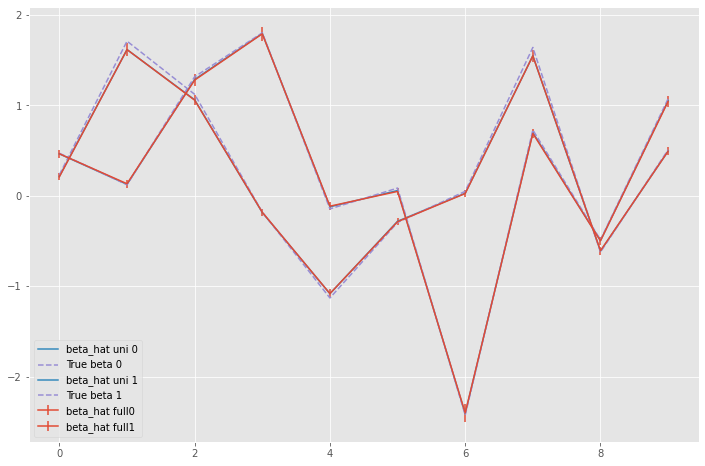

(DeviceArray(-0.6061551, dtype=float32), DeviceArray(1.2268388, dtype=float32))

In [27]:
plt.figure(figsize=(12, 8))

for i in range(q):
    plt.errorbar(range(p), params.beta[:, i], yerr=1.96 * std_beta[:, i], color='C0', label=f'beta_hat full{i}')
    plt.plot(range(p), beta_hat[:, i], color='C1', label=f'beta_hat uni {i}')
    plt.plot(beta[:, i], color='C2', linestyle='--', label=f'True beta {i}')

plt.legend()
plt.show()

z_scores = (params.beta - beta) / std_beta
z_scores.mean(), z_scores.std()

The standard errors look reasonable and the z-scores have a standard error of around 1.2, where we would have expected something closer to 1.
They may therefore a bit larger than what they should be.


#### Confidence interval for $\Sigma$ (Work in progress)
Getting a confidence interval for the correlation may prove a bit harder since we estimated $s$ which is an overparametrization of the covariance matrix. An other difficulty is that it is more complicated to get $s$ from sigma than the reverse. To get $s$ from $\Sigma$, we need to find the square root of the matrix, which can involve diagonilisation and heavier linear algebra. This heavier linear algebra is in particular more difficult to differentiate (at least for JAX) and my attempts to directly write the likelihood as a function of $\Sigma$ have failed.

It is, however significantly easier to transform $s$ to $\Sigma$ by the function we laid out during the parametrization step. The idea is therefore to use the Delta method on the approximate distribution that $s$ follows to get an approximate normal distribution for $\Sigma$. Here since $q=2$, we will focus on the only off-diagonal term $\rho$ which is the correlation between the two residual responses.



In [28]:
# First, let's estimate the distribution of s

key, skey = random.split(key)

def loss2(s_flat):
    s = s_flat.reshape(q, q)
    return loss(Params(beta=params.beta, s=s), x, y, key, m=2000)

hloss2 = jax.jit(jax.hessian(loss2))
h = hloss2(params.s.flatten())
cov_s = jnp.linalg.inv(h) / n
cov_s

DeviceArray([[-1.022775  , -0.9354552 ,  0.46122187,  0.11874567],
             [-0.93545556, -0.45180845,  0.14091502,  0.2906434 ],
             [ 0.46122235,  0.14091532,  0.741432  , -0.6839868 ],
             [ 0.1187453 ,  0.29064313, -0.68398666,  0.8697458 ]],            dtype=float32)

Now, we are supposed to have the covariance of $s$ (per the maximum likelihod estimation).

Thanks to the Delta method, if $\hat s \sim N(s, \Sigma_s)$ and $\rho = f(s)$
then we should have $$ \hat \rho = f(\hat s) \sim N(f(s) = \rho, \nabla_s f^T  \Sigma_s \nabla_s f)$$ as long as the variations of $s$ are within a fairly linear portion of $f$.

In [29]:
# s to rho
def s_to_rho(s_flat):
    s = s_flat.reshape(q, q)
    t = s.T @ s
    S = t + jnp.eye(q)
    sqrt_diag = jnp.sqrt(jnp.diag(S))
    S = (S / sqrt_diag).T / sqrt_diag
    return S[0, 1]

s_to_rho(params.s)
g_s = jax.grad(s_to_rho)(params.s.flatten())
v_rho = g_s.T @ cov_s @ g_s
std_rho = jnp.sqrt(v_rho)
std_rho

DeviceArray(0.02078384, dtype=float32)

This seems to conclude that the standard error on $\hat \rho$ is about 2%.
It is a bit hard to validate since bootstrapping would be very slow. At a minimum, it is believeable.

Note that there are unadressed theoretical problems with this approach: 
- The attentive reader may have noticed that the "Covariance" for $s$ is not positive semi-definite. This prevents it from being a valid covariance matrix. Moreover, maximum likelihood estimation applies when the model is identifiable, which is not the case here as several different s can lead to the same $\Sigma$.
- Nonetheless, when repeating the computation with different random seeds, the standard error for rho is stable, which at least does not indicate any numerical instability. 
- There is therefore work to be done to confirm or falsify this procedure to get standard errors for $\rho$.


In [30]:
# step 1: graphical confirmation
# step 2: justification using hessian chain rule, or defining the adjoint of sqrtm?


In [31]:
def rho_to_s(rho):
    sigma = jnp.array([
        [1.0, rho],
        [rho, 1.0],
    ])

    r = sigma / (1 - rho) - jnp.eye(q)
    sqrt_r = jnp.real(jax.scipy.linalg.sqrtm(r))
    return sqrt_r



In [47]:
losses = []
rho_s = jnp.linspace(.88, .93, num=10)
for rho in rho_s:
    print(rho)
    # key, skey = random.split(key)
    losses.append(loss(Params(beta=params.beta, s=rho_to_s(rho)), x, y, skey, m=4_000))

0.88
0.88555557
0.89111114
0.89666665
0.9022222
0.9077777
0.9133333
0.91888887
0.92444444
0.93


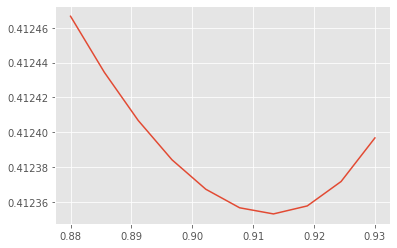

In [48]:
plt.plot(rho_s, losses)

In [ ]:
# Actually: even for beta, s needs to be taken into account, otherwise the noise is not properly estimated.
# Steps:
# - define the adjoint for sqrtm() 3
# - find a custom way to write a chain rule for the hessian? 2
# - try to at least compute beta with errors? 1


In [ ]:
# First beta_hat 

In [28]:
# standard errors on beta

def loss3(beta_flat):
    beta = beta_flat.reshape(p, q)
    return loss(Params(beta=beta, s=params.s), x, y, key, m=2000)

h_beta = jax.jit(jax.hessian(loss3))(params.beta.flatten())
std_beta = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_beta) / n))
std_beta = std_beta.reshape(p, q)


In [30]:
params

Params(beta=DeviceArray([[ 0.20963061,  0.46390548],
             [ 1.6158957 ,  0.13235399],
             [ 1.056665  ,  1.2785257 ],
             [-0.1830934 ,  1.7900403 ],
             [-1.0822527 , -0.11558545],
             [-0.28715566,  0.0475706 ],
             [ 0.0244156 , -2.4018    ],
             [ 1.5471694 ,  0.6891748 ],
             [-0.60846454, -0.4982784 ],
             [ 0.49231958,  1.0430812 ]], dtype=float32), s=DeviceArray([[0.7168485, 0.7224643],
             [2.9044561, 2.9824722]], dtype=float32))

In [77]:
key, skey = random.split(key)

flat_params, unflatten_params = jax.flatten_util.ravel_pytree(params)

def loss3(flat_params):
    params = unflatten_params(flat_params)
    return loss(params, x, y, key, m=1_000)

h_params = jax.jit(jax.hessian(loss3))(flat_params)
std_params = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_params) / n)) # we should not really invert a hessian that is not clearly psd.

std_params = unflatten_params(std_params)
std_beta = std_params.beta

In [78]:
# jax.grad(jax.scipy.linalg.sqrtm)(params.s)

In [82]:
jnp.linalg.eigvalsh(h_params)

DeviceArray([-5.7253204e-05,  8.2048689e-05,  3.8604427e-04,
              5.3798006e-04,  1.8664546e-02,  3.5076208e-02,
              1.7457931e-01,  1.7983878e-01,  1.8333009e-01,
              1.8545291e-01,  1.8766439e-01,  1.9055977e-01,
              1.9236389e-01,  1.9593984e-01,  2.0373614e-01,
              2.3965967e-01,  2.9740742e-01,  3.0799359e-01,
              3.1437415e-01,  3.1804961e-01,  3.3460018e-01,
              3.4065986e-01,  3.4379581e-01,  3.5535133e-01],            dtype=float32)

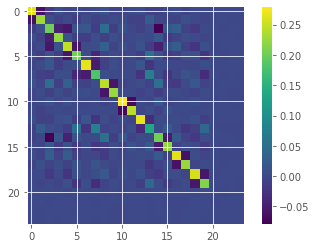

In [79]:
plt.imshow(h_params)
plt.colorbar()
plt.show()

In [80]:
std_params

Params(beta=DeviceArray([[0.02036791, 0.02328998],
             [0.0350049 , 0.02195705],
             [0.02737422, 0.03292083],
             [0.02020774, 0.0404618 ],
             [0.02742214, 0.02184756],
             [0.02021084, 0.02112321],
             [0.01971373, 0.05136713],
             [0.03398252, 0.02497915],
             [0.02241254, 0.02362361],
             [0.02192742, 0.02989938]], dtype=float32), s=DeviceArray([[       nan,        nan],
             [0.84002227, 0.69689256]], dtype=float32))

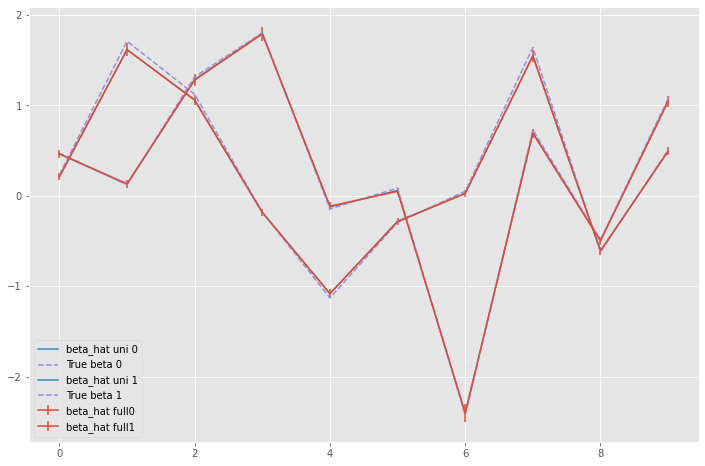

(DeviceArray(-0.60423905, dtype=float32),
 DeviceArray(1.2211479, dtype=float32))

In [81]:
plt.figure(figsize=(12, 8))

for i in range(q):
    plt.errorbar(range(p), params.beta[:, i], yerr=1.96 * std_beta[:, i], color='C0', label=f'beta_hat full{i}')
    plt.plot(range(p), beta_hat[:, i], color='C1', label=f'beta_hat uni {i}')
    plt.plot(beta[:, i], color='C2', linestyle='--', label=f'True beta {i}')

plt.legend()
plt.show()

z_scores = (params.beta - beta) / std_beta
z_scores.mean(), z_scores.std()

In [49]:
key, skey = random.split(key)

flat_params, unflatten_params = jax.flatten_util.ravel_pytree(params)

def loss3(flat_params):
    params = unflatten_params(flat_params)
    return loss(params, x, y, key, m=1_000)

h_params = jax.jit(jax.hessian(loss3))(flat_params)
std_params = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_params) / n)) # we should not really invert a hessian that is not clearly psd.

std_params = unflatten_params(std_params)
std_beta = std_params.beta

Params(beta=DeviceArray([[0.01945504, 0.02289228],
             [0.03042907, 0.02094529],
             [0.02348883, 0.0294145 ],
             [0.01965133, 0.03080569],
             [0.01776946, 0.0209442 ],
             [0.0157473 , 0.01969732],
             [0.01822473, 0.03836037],
             [0.0131612 , 0.02182292],
             [0.02133205, 0.01990104],
             [0.02087005, 0.02628603]], dtype=float32), s=DeviceArray([[       nan, 0.19617933],
             [       nan,        nan]], dtype=float32))

In [91]:
# tests

msquare = lambda x: x @ x

gsquare = jax.jacobian(msquare)
msquare(params.s)

DeviceArray([[ 2.6122377,  2.6726272],
             [10.744514 , 10.993506 ]], dtype=float32)

In [98]:
gsquare(params.s).shape

(2, 2, 2, 2)

In [120]:
def flat_square(flat_x, q):
    x = flat_x.reshape((q, q))
    x2 = x @ x
    return x2.flatten()

flat_square(params.s.flatten(), q)
g_flat_square = jax.jacrev(flat_square)


# idea

def g_sqrtm(x):
    q = x.shape[0]
    y = jnp.real(jax.scipy.linalg.sqrtm(x))
    y_flat = y.flatten()
    dx_dy = g_flat_square(y_flat, q)
    dy_dx = jnp.linalg.inv(dx_dy)
    dy_dx = dy_dx.reshape((q, q, q, q))
    return dy_dx



In [122]:
g_flat_square(params.s.flatten(), q)

DeviceArray([[1.433697 , 2.9044561, 0.7224643, 0.       ],
             [0.7224643, 3.6993208, 0.       , 0.7224643],
             [2.9044561, 0.       , 3.6993208, 2.9044561],
             [0.       , 2.9044561, 0.7224643, 5.9649444]], dtype=float32)

In [123]:
g_sqrtm(params.s)

DeviceArray([[[[ 3.3128517 , -2.7988632 ],
               [-0.696199  ,  0.63557327]],

              [[-0.69619894,  1.1295954 ],
               [ 0.15809467, -0.20041955]]],


             [[[-2.7988632 ,  2.5551348 ],
               [ 1.1295954 , -0.80572784]],

              [[ 0.63557315, -0.8057277 ],
               [-0.20041953,  0.50108665]]]], dtype=float32)

In [126]:
g_sqrtm(jnp.eye(2))

DeviceArray([[[[0.5, 0. ],
               [0. , 0. ]],

              [[0. , 0.5],
               [0. , 0. ]]],


             [[[0. , 0. ],
               [0.5, 0. ]],

              [[0. , 0. ],
               [0. , 0.5]]]], dtype=float32)

In [127]:
gsquare(jnp.eye(2))

DeviceArray([[[[2., 0.],
               [0., 0.]],

              [[0., 2.],
               [0., 0.]]],


             [[[0., 0.],
               [2., 0.]],

              [[0., 0.],
               [0., 2.]]]], dtype=float32)

In [204]:

@jax.custom_jvp
def real_sqrtm(x):
    return jnp.real(jax.scipy.linalg.sqrtm(x))

@real_sqrtm.defjvp
def real_sqrtm_jvp(primals, tangents):
    x, = primals
    x_dot, = tangents
    y = real_sqrtm(x)
    
    q = x.shape[0]
    y_flat = y.flatten()
    dx_dy = g_flat_square(y_flat, q)
    # dy_dx = jnp.linalg.inv(dx_dy)
    # y_dot_flat = dy_dx @ x_dot.flatten()
    y_dot_flat = jnp.linalg.solve(dx_dy, x_dot.flatten())
    y_dot = y_dot_flat.reshape((q, q))

    return y, y_dot


In [205]:
real_sqrtm_jvp((jnp.eye(2), ), (jnp.eye(2), ))

(DeviceArray([[1., 0.],
              [0., 1.]], dtype=float32),
 DeviceArray([[0.5, 0. ],
              [0. , 0.5]], dtype=float32))

In [206]:
jax.test_util.check_grads(real_sqrtm, (0.5*jnp.eye(3),), 1)

In [228]:
key, skey = random.split(key)
X = random.normal(key, (3, 3))
jax.test_util.check_grads(real_sqrtm, (X @ X,), 1)


In [363]:
jax.test_util.check_grads(real_sqrtm, (X @ X,), 1)

In [365]:
# Very promising!



In [446]:
def rho_to_s(rho):
    sigma = jnp.array([
        [1.0, rho],
        [rho, 1.0],
    ])

    # r = sigma / (1 - rho) - jnp.eye(q)
    r = sigma * 20 - jnp.eye(q)
    sqrt_r = real_sqrtm(r)
    return sqrt_r


rho_to_s(0.9)


DeviceArray([[3.5413818, 2.5413816],
             [2.5413816, 3.5413814]], dtype=float32)

In [448]:
key, skey = random.split(key)

def loss3(rho):
    s = rho_to_s(rho)
    return loss(Params(beta=params.beta, s=s), x, y, key, m=2_000)

rho_hat = params.sigma[0, 1]
h_rho = jax.jit(jax.hessian(loss3))(rho_hat)
rho_hat_std = jnp.sqrt(1 / h_rho / n)
rho_hat_std

DeviceArray(0.02255926, dtype=float32)

DeviceArray(0.02176441, dtype=float32)

DeviceArray(0.00044194, dtype=float32)

In [392]:
params.sigma

DeviceArray([[1.        , 0.9017381 ],
             [0.90173817, 1.0000001 ]], dtype=float32)

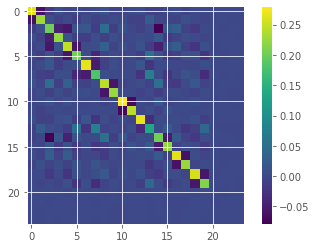

In [362]:
plt.imshow(h_params)
plt.colorbar()

In [114]:
Params(beta=params.beta, s=rho_to_s(rho)).sigma

DeviceArray([[0.99999994, 0.90999997],
             [0.90999997, 1.        ]], dtype=float32)

In [115]:
rho

DeviceArray(0.91, dtype=float32)

In [34]:
params.sigma

DeviceArray([[1.        , 0.9017381 ],
             [0.90173817, 1.0000001 ]], dtype=float32)

In [140]:
v_rho = g_s.T @ jnp.linalg.inv(h) / n @ g_s
std_rho = jnp.sqrt(v_rho)

In [141]:
std_rho

DeviceArray(0.00592196, dtype=float32)

In [192]:
s_to_rho(params.s) + jnp.array([-1, 1]) * 1.96 * std_rho

DeviceArray([0.8908106, 0.9140247], dtype=float32)

In [205]:
# standard errors on beta

def loss3(beta):
    beta = beta.reshape(p, q)
    return loss(Params(beta=beta, s=params.s), x, y, key, m=4000)
    
h_beta = jax.jit(jax.hessian(loss3))(params.beta.flatten())
std_beta = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_beta) / n))
std_beta = std_beta.reshape(p, q)


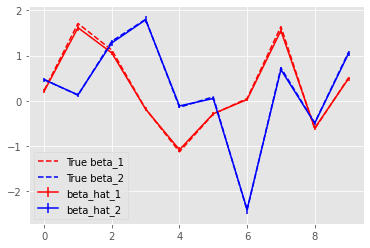

In [206]:
plt.errorbar(x=range(p), y=params.beta[:, 0], yerr=1.96*std_beta[:, 0], color='r', label="beta_hat_1")
plt.errorbar(x=range(p), y=params.beta[:, 1], yerr=1.96*std_beta[:, 1], color='b', label="beta_hat_2")

plt.plot(true_params.beta[:, 0], '--', color='r', label="True beta_1")
plt.plot(true_params.beta[:, 1], '--', color='b', label="True beta_2")

plt.legend()
plt.show()

(array([3., 0., 2., 3., 2., 4., 2., 2., 0., 2.]),
 array([-2.6753209 , -2.239151  , -1.8029811 , -1.3668112 , -0.9306413 ,
        -0.49447143, -0.05830155,  0.37786835,  0.8140382 ,  1.2502081 ,
         1.686378  ], dtype=float32),
 <BarContainer object of 10 artists>)

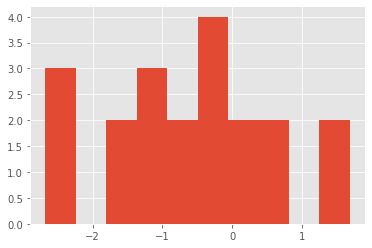

In [207]:
z_scores = (params.beta - true_params.beta) / std_beta
p_values = jax.scipy.stats.norm.cdf(z_scores)
plt.hist(z_scores.flatten())

In [208]:
z_scores.std()

DeviceArray(1.207118, dtype=float32)

In [204]:
# Seems like the hessian method is giving standard errors that are 20% too small, which is pretty good.


In [189]:
# Other methods?


In [ ]:
import 

In [86]:
import jax.lax as lax

In [1]:
# Sampling approaches (bayesian methods)

def 

In [ ]:
jax.random.multivariate_normal()

In [163]:

def trunc_normal_once(key, y, mean, sqrt_cov):
    """Basic rejection sampling"""
    key, skey = random.split(key)
    u = mean + sqrt_cov @ random.normal(skey, y.shape)
    
    def cond(state):
        key, u = state
        return jnp.any(u * y < 0)
    
    def body(state):
        key, u = state
        key, skey = random.split(key)
        u = mean + sqrt_cov @ random.normal(skey, y.shape)
        return key, u
    
    key, u = lax.while_loop(cond, body, (key, u))
    return u

@jax.jit
def trunc_normal(key, y, mean, cov):
    sqrt_cov = jnp.real(jax.scipy.linalg.sqrtm(cov))
    keys = random.split(key, y.shape[0])
    y = (y - .5) * 2
    u = jax.vmap(trunc_normal_once, in_axes=(0, 0, 0, None))(keys, y, mean, sqrt_cov)
    return u


In [164]:
%%time
key, skey = random.split(key)
trunc_normal_once(skey, y[0], mean=0, sqrt_cov=jnp.eye(2))

CPU times: user 218 ms, sys: 4.61 ms, total: 223 ms
Wall time: 218 ms


DeviceArray([1.1046749, 0.5076443], dtype=float32)

In [220]:
# want to count number of trials before getting a sample

def trunc_normal_once(key, y, mean, sqrt_cov):
    """Basic rejection sampling"""
    key, skey = random.split(key)
    u = mean + sqrt_cov @ random.normal(skey, y.shape)
    
    def cond(state):
        key, u, n = state
        return jnp.any(u * y < 0)
    
    def body(state):
        key, u, n = state
        key, skey = random.split(key)
        u = mean + sqrt_cov @ random.normal(skey, y.shape)
        n += 1
        return key, u, n
    
    key, u, n = lax.while_loop(cond, body, (key, u, 1))
    return u, n

@jax.jit
def trunc_normal(key, y, mean, cov):
    sqrt_cov = jnp.real(jax.scipy.linalg.sqrtm(cov))
    keys = random.split(key, y.shape[0])
    y = (y - .5) * 2
    u = jax.vmap(trunc_normal_once, in_axes=(0, 0, 0, None))(keys, y, mean, sqrt_cov)
    return u

In [237]:
key, skey = random.split(key)
trunc_normal_once(skey, y[0], mean=0, sqrt_cov=jnp.eye(2))

(DeviceArray([0.06690047, 1.2455676 ], dtype=float32),
 DeviceArray(4, dtype=int32, weak_type=True))

In [238]:
key, skey = random.split(key)
y_star_sample, n_sample = trunc_normal(key, y, mean, sigma)

(array([9.998e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 2.8140e+02, 5.6180e+02, 8.4220e+02, 1.1226e+03,
        1.4030e+03, 1.6834e+03, 1.9638e+03, 2.2442e+03, 2.5246e+03,
        2.8050e+03]),
 <BarContainer object of 10 artists>)

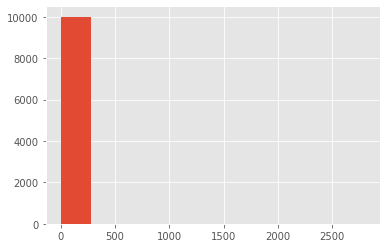

In [239]:
plt.hist(n_sample)

In [240]:
import pandas as pd

pd.Series(n_sample).describe()

count    10000.00000
mean         2.58880
std         29.28805
min          1.00000
25%          1.00000
50%          1.00000
75%          2.00000
max       2805.00000
dtype: float64

In [243]:
x[n_sample>1000], y[n_sample>1000]

(DeviceArray([[ 2.159742  , -0.98615766, -0.3761659 , -0.09680148,
                0.3850434 ,  0.10492848, -0.6940525 ,  0.20944649,
                1.1132071 , -1.2560453 ]], dtype=float32),
 DeviceArray([[1, 1]], dtype=int32))

In [244]:
(x @ beta)[n_sample>1000]

DeviceArray([[-3.0770478 ,  0.12355447]], dtype=float32)

In [165]:
mean = x @ beta
sigma

DeviceArray([[1. , 0.9],
             [0.9, 1. ]], dtype=float32)

In [167]:
%%time
y_star_sample = trunc_normal(key, y, mean, sigma)

CPU times: user 6.21 s, sys: 5.6 s, total: 11.8 s
Wall time: 4.83 s


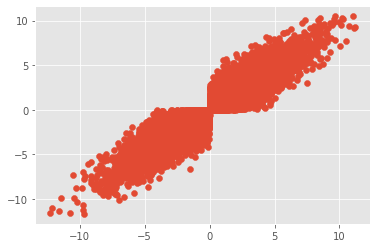

In [175]:
plt.scatter(y_star_mu[:, 0], y_star_sample[:, 0])

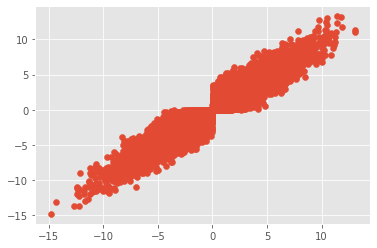

In [176]:
plt.scatter(y_star_mu[:, 1], y_star_sample[:, 1])

In [177]:
eps = y_star_sample - mean

In [181]:
jnp.mean(eps, axis=0), jnp.std(eps, axis=0)

(DeviceArray([0.00497848, 0.01305609], dtype=float32),
 DeviceArray([1.0146297, 1.0100081], dtype=float32))

In [183]:
jnp.corrcoef(eps.T)

DeviceArray([[1.        , 0.90221393],
             [0.90221393, 1.        ]], dtype=float32)

In [191]:
# fit multivariate linear regression

beta_hat = jnp.linalg.solve(x.T @ x, x.T @ y_star_mu)

In [192]:
beta_hat / beta

DeviceArray([[1.0243322 , 1.0189387 ],
             [0.9974448 , 0.97601026],
             [0.9831262 , 0.9877366 ],
             [1.0184389 , 0.99906915],
             [0.99103063, 0.9252699 ],
             [0.98279214, 1.0952549 ],
             [0.6354604 , 1.0071455 ],
             [0.99918485, 1.0012058 ],
             [1.0074484 , 1.0122432 ],
             [0.9906767 , 0.9956854 ]], dtype=float32)

In [198]:
beta

DeviceArray([[ 0.23186858,  0.46960872],
             [ 1.709085  ,  0.12174629],
             [ 1.1210241 ,  1.3156708 ],
             [-0.1811214 ,  1.8010722 ],
             [-1.1304141 , -0.14554782],
             [-0.29495806,  0.08470398],
             [ 0.04848719, -2.4250152 ],
             [ 1.6395696 ,  0.7269019 ],
             [-0.6232631 , -0.48760355],
             [ 0.5079111 ,  1.0722051 ]], dtype=float32)

In [213]:
%%time

# attempt at fitting by EM?

from time import time

def fit_em(key):
    beta_hat = jnp.zeros((x.shape[1], y.shape[1]))
    sigma_hat = jnp.eye(y.shape[1])
    start = time()
    hist = {
        'beta': [beta_hat],
        'sigma': [sigma_hat],
    }
    
    for i in range(1000):
        mean = x @ beta_hat
        key, skey = random.split(key)
        
        y_star_sample = trunc_normal(skey, y, mean, sigma_hat)
        beta_hat = jnp.linalg.solve(x.T @ x, x.T @ y_star_sample)
        eps = y_star_sample - mean
        sigma_hat = jnp.corrcoef(eps.T)
        sqrt_diag = jnp.sqrt(jnp.diag(sigma_hat))
        sigma_hat = (sigma_hat / sqrt_diag).T / sqrt_diag
        
        hist['beta'].append(beta_hat)
        hist['sigma'].append(sigma_hat)
        
        if i % 10 == 0:
            print(f"{i=}, "
                  f"norm(beta_hat - beta)={jnp.linalg.norm(beta_hat - beta): .2f}, "
                  f"rho={sigma_hat[0, 1]: .2f}, "
                  f"iteration_time={time() - start: .2f}"
                  )
            start = time()
    return beta_hat, sigma_hat, hist

beta_hat, sigma_hat, hist = fit_em(key)

i=0, norm(beta_hat - beta)= 3.85, rho= 0.14, iteration_time= 0.14
i=10, norm(beta_hat - beta)= 2.09, rho= 0.22, iteration_time= 2.53
i=20, norm(beta_hat - beta)= 1.51, rho= 0.31, iteration_time= 7.31
i=30, norm(beta_hat - beta)= 1.20, rho= 0.38, iteration_time= 11.77
i=40, norm(beta_hat - beta)= 0.90, rho= 0.41, iteration_time= 20.46
i=50, norm(beta_hat - beta)= 0.78, rho= 0.45, iteration_time= 29.09
i=60, norm(beta_hat - beta)= 0.67, rho= 0.52, iteration_time= 32.37
i=70, norm(beta_hat - beta)= 0.55, rho= 0.53, iteration_time= 25.97
i=80, norm(beta_hat - beta)= 0.49, rho= 0.55, iteration_time= 29.07
i=90, norm(beta_hat - beta)= 0.41, rho= 0.57, iteration_time= 28.99
i=100, norm(beta_hat - beta)= 0.41, rho= 0.62, iteration_time= 37.05
i=110, norm(beta_hat - beta)= 0.33, rho= 0.61, iteration_time= 70.32
i=120, norm(beta_hat - beta)= 0.32, rho= 0.64, iteration_time= 58.58
i=130, norm(beta_hat - beta)= 0.30, rho= 0.68, iteration_time= 54.86
i=140, norm(beta_hat - beta)= 0.28, rho= 0.73, i

In [215]:
beta_hat / beta

DeviceArray([[0.92621744, 0.97317946],
             [0.935618  , 1.2108839 ],
             [0.9376495 , 0.99230945],
             [0.92762756, 0.99776363],
             [0.96374685, 0.85794413],
             [0.9482989 , 0.87917423],
             [0.34276232, 0.99682015],
             [0.93596506, 0.97687566],
             [0.96770996, 1.0237529 ],
             [0.96564347, 0.95992374]], dtype=float32)

In [217]:
sigma_hat

DeviceArray([[1.       , 0.9313076],
             [0.9313076, 1.       ]], dtype=float32)